### Gadi path set-up

In [14]:
import os
nci_user_name = "abc123"   ### change this to your NCI user name
work_path = pathlib.Path("/g/data/nm05/workspace/").joinpath(nci_user_name)
source_folder = pathlib.Path("/g/data/nm05/workshop_data/time_series/synthetic")

### Comment these three lines below, which are here for pre-workshop testing
work_path = pathlib.Path().home().joinpath("aurora_test_folder")
work_path.mkdir(parents=True, exist_ok=True)
source_folder = pathlib.Path().home().joinpath("software", "irismt", "mt_examples", "data", "time_series", "synthetic")

os.chdir(work_path)
target_folder = work_path

## Process Synthetic Data with Aurora

This notebook shows how to process MTH5 data from a synthetic dataset.

Steps
1. Create the synthetic mth5
2. Get a Run Summary from the mth5
3. Select the station to process and optionally the remote reference station
4. Create a processing config
5. Generate TFs
6. Archive the TFs (in emtf_xml or z-file)

### Here are the modules we will need to import 

In [12]:
import pathlib
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.test_utils.synthetic.make_mth5_from_asc import create_test12rr_h5
from aurora.test_utils.synthetic.paths import SyntheticTestPaths
from aurora.transfer_function.kernel_dataset import KernelDataset

warnings.filterwarnings('ignore')

## Define target folder and mth5 path

By default, the synthetic mth5 file is used for testing in `aurora/data/synthetic/mth5` and probably already exists on your system if you have run the tests. In the code below, we check if the file exists already, and if not we make it.

**NOTE 1:** If using a read-only HPC installation, you may not be able to write to the directory where aurora is installed.  In that case, defining your target path as somewhere you have write permission.  In that case, uncommment the READ ONLY INSTALLATION block below.
**NOTE 2:** If using a pip or conda-forge install, the data may not be in your installation.  The data are in mt_examples/data/time_series/synthetic/.
To access this way, uncomment the lines below `#Source data from mt_examples`



In [13]:
synthetic_test_paths = SyntheticTestPaths()
source_folder = synthetic_test_paths.ascii_data_path # access from the installed aurora path
target_folder = synthetic_test_paths.mth5_path

### Gadi path set-up

In [3]:
import os
nci_user_name = "abc123"   ### change this to your NCI user name
work_path = pathlib.Path("/g/data/nm05/workspace/").joinpath(nci_user_name)
source_folder = pathlib.Path("/g/data/nm05/workshop_data/time_series/synthetic")

### Comment these three lines below, which are here for pre-workshop testing
work_path = pathlib.Path().home().joinpath("aurora_test_folder")
work_path.mkdir(parents=True, exist_ok=True)
source_folder = pathlib.Path().home().joinpath("software", "irismt", "mt_examples", "data", "time_series", "synthetic")

os.chdir(work_path)
target_folder = work_path

In [4]:
mth5_path = target_folder.joinpath("test12rr.h5")

If the mth5 doesn't already exist, or you want to re-make it, call `create_test12rr_h5()`

In [5]:
if not mth5_path.exists():
    created_path = create_test12rr_h5(target_folder=target_folder, source_folder=source_folder)   
    assert created_path == mth5_path


## Get a Run Summary

Note that we didn't need to explicitly open the mth5 to do that, we can pass the path if we want.
Run summary takes a list of mth5 paths as input argument.

In [6]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary

2023-11-14T16:43:40.942068-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/test12rr.h5


,survey,station_id,run_id,start,end
0,none,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00
1,none,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00


## Define a Kernel Dataset


In [7]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,none,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,none,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


## Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration.

The config will get its information about the specific stations to process via the kernel dataset.

**NOTE:** When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [8]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# you can export the config to a json by uncommenting the following line
# cfg_json = config.to_json()

2023-11-14T16:43:40.991890-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


## Take a look at the processing configuration

In [9]:
config

{
    "processing": {
        "band_setup_file": "/home/kkappler/anaconda3/envs/pypi/lib/python3.9/site-packages/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                        

## Call process_mth5

2023-11-14T16:43:41.047619-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
  survey station_id run_id  valid  remote  duration     fc dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   none      test1    001   True   False   39999.0  False         0         1.0     1.000000            128.0                 128      39999.0             416.0
1   none      test1    001   True   False   39999.0  False         1         4.0     0.250000            512.0                 128       9999.0             103.0
2   none      test1    001   True   False   39999.0  False         2         4.0     0.062500           2048.0                 128       2499.0              25.0
3   none      test1    001   True   False   39999.0  False         3         4.0     0.015625           8192.0                 128        624.0               6.0
4   none      test2    001   True    True   39999

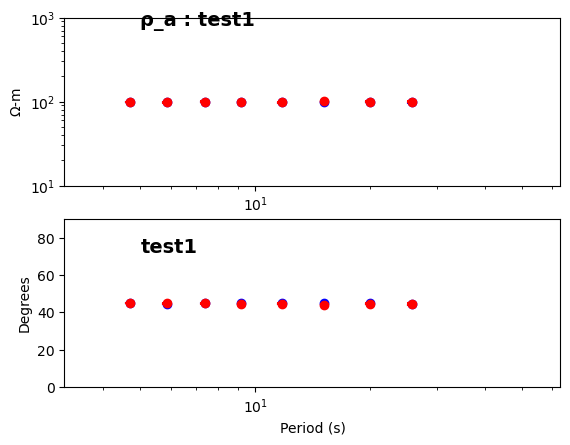

DECIMATION LEVEL 1
2023-11-14T16:43:43.698077-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
2023-11-14T16:43:43.905041-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-14T16:43:44.109748-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s


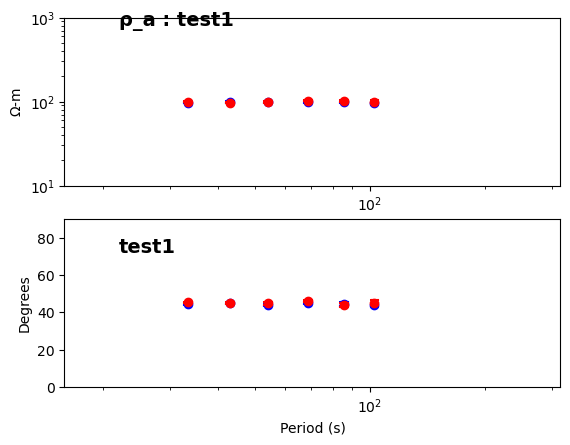

DECIMATION LEVEL 2
2023-11-14T16:43:44.928019-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
2023-11-14T16:43:45.085588-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-14T16:43:45.240418-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s


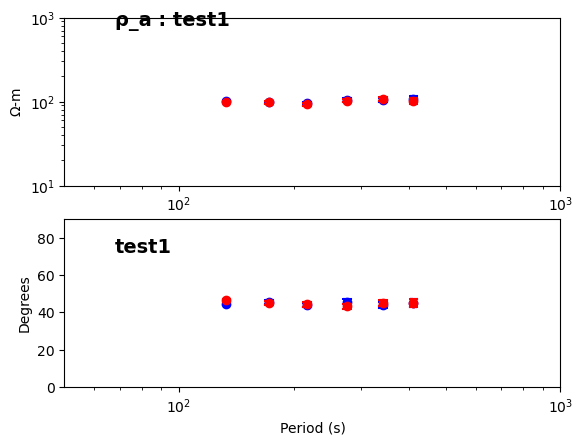

DECIMATION LEVEL 3
2023-11-14T16:43:46.120124-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
2023-11-14T16:43:46.277595-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
2023-11-14T16:43:46.430077-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False False
Processing band 1514.701336s
Processing band 1042.488956s
Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s


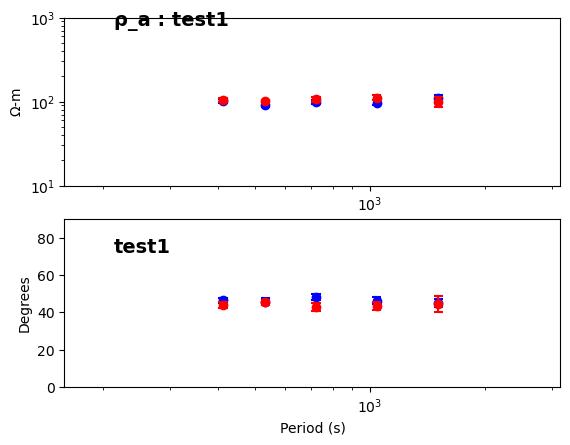

2023-11-14T16:43:47.284304-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/test12rr.h5
2023-11-14T16:43:47.284877-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/aurora_test_folder/test12rr.h5


In [10]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

In [11]:
xml_file_base = f"synthetic_test1.xml"
tf_cls.write(fn=xml_file_base, file_type="emtfxml")


EMTFXML(station='test1', latitude=0.00, longitude=0.00, elevation=0.00)